In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import shap

from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols, convert_categorical_to_ordinal
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import MIHM, IndexPredictionModel
from mihm.model.mihm_dataset import MIHMDataset
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "chd2016", "dep2016", "adl2016", 
            "living2016", "division"]

df = pd.read_stata('../HeatResilience.dta', columns=read_cols)

In [3]:
categorical_cols = ['female', 'racethn', 'urban', 'mar_cat2', "psyche2016", "stroke2016", 
                    "hibpe2016", "diabe2016", "hearte2016",  'living2016', 'division',]
ordinal_cols = ["smoke2016",  'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016']
continuous_cols = ['eduy', 'ihs_wealthf2016', 'age2016', 'pmono','bmi2016', 'tractdis', 'chd2016', 'dep2016', 'adl2016', "m_HeatIndex_7d",
                    "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
for c in categorical_cols:
    df[c] = df[c].astype("category")
# categorical = [c for c in df.columns if df[c].dtype == "category"]
# separate binary vs multicategory cols
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [4]:
# Preprocess df for model
df = binary_to_one_hot(df, binary_cats) # convert binary to one hot
df = multi_cat_to_one_hot(df, multi_cats) # convert multi cat to one hot
df = convert_categorical_to_ordinal(df, ordinal_cols) # convert ordinal to ordinal
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_cols+ordinal_cols) # standardize continuous cols
df_norm.dropna(inplace=True) # drop Nan rows

In [5]:
input_cols = ['female', 'eduy', 'ihs_wealthf2016', 'pmono', 'bmi2016', "age2016",
            'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
            'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
            'smoke2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016', # ordinals
            'racethn_0. NHW', 'racethn_1. NHB', 'racethn_2. Hispanic', 'racethn_3. Others', # multi cats
            'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
            'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
            "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
controlled_cols = [
    "m_HeatIndex_7d",
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = [
    "female", "racethn_0. NHW", "racethn_1. NHB", "racethn_2. Hispanic", "racethn_3. Others",
    'eduy', 'ihs_wealthf2016', 'bmi2016', 
    'tractdis', 'mar_cat2', 'psyche2016', 'stroke2016', 'hibpe2016', 
    'diabe2016', 'hearte2016', 'chd2016', 'dep2016', 'adl2016', 'living2016', 
    'smoke2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
    'urban_1. urban', 'urban_2. suurban (code 2)', 'urban_3. ex-urban', 
    'division_Northeast', 'division_Midwest', 'division_South', 'division_West',
]

In [6]:
# interactor
heat_cont_np = df_norm["m_HeatIndex_7d"].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["zPCPhenoAge_acc"].to_numpy()

In [7]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3325


## Load model and predict

In [8]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model = IndexPredictionModel(interaction_var_size, hidden_layer_sizes)

In [16]:
state_dict = torch.load('../checkpoints/Feb2_heat_model_sp.pth')
state_dict_index = get_index_prediction_weights(state_dict)
model.load_state_dict(state_dict_index)
model.cuda().eval()

IndexPredictionModel(
  (layers): ModuleList(
    (0): Linear(in_features=31, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [17]:
state_dict

OrderedDict([('main_weight', tensor([[-0.8092]])),
             ('interaction_weight', tensor([[1.0184]])),
             ('constant', tensor([[-0.1032]])),
             ('interactor_bias', tensor([[-1.2623]])),
             ('layers.0.weight',
              tensor([[-0.3192, -0.1765, -0.1676,  ...,  0.0252, -0.0033,  0.0544],
                      [-0.3559, -0.1113, -0.3188,  ...,  0.1942,  0.2217,  0.0667],
                      [-0.3876, -0.1943, -0.0447,  ..., -0.2849, -0.0763, -0.0986],
                      ...,
                      [ 0.2717, -0.1326,  0.3371,  ..., -0.0964,  0.0677, -0.2086],
                      [-0.1786,  0.0050,  0.1383,  ...,  0.1900, -0.1390, -0.0844],
                      [-0.2894,  0.2385,  0.0580,  ...,  0.1566,  0.1019, -0.3528]])),
             ('layers.0.bias',
              tensor([-0.0926, -0.1627,  0.0184,  0.0692,  0.1367,  0.0427,  0.3221,  0.0110,
                       0.0500, -0.1934,  0.0806,  0.0665,  0.1139, -0.2291,  0.1367,  0.0521,
   

In [10]:
interaction_vars_torch = torch.from_numpy(interaction_vars_np.astype('float32')).cuda()
explainer = shap.DeepExplainer(model, interaction_vars_torch)

In [11]:
shap_values = explainer.shap_values(interaction_vars_torch[:1000], check_additivity=False)

In [12]:
# save shap values
import numpy as np
np.save("shap_values_heat_v2.npy", shap_values)

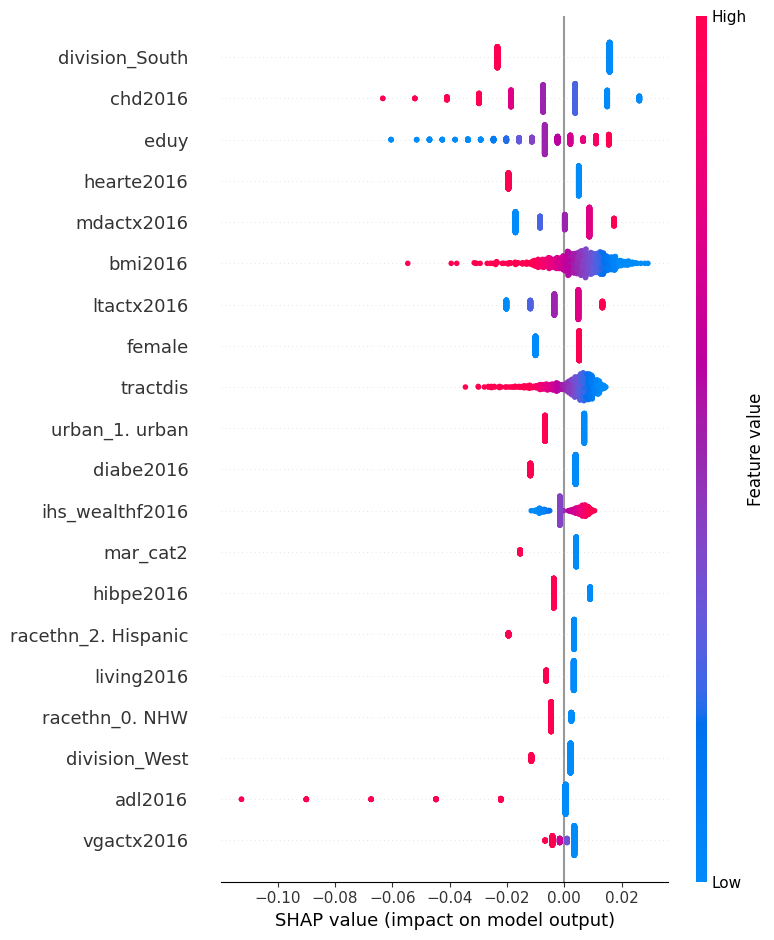

In [13]:
shap.initjs()
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors)

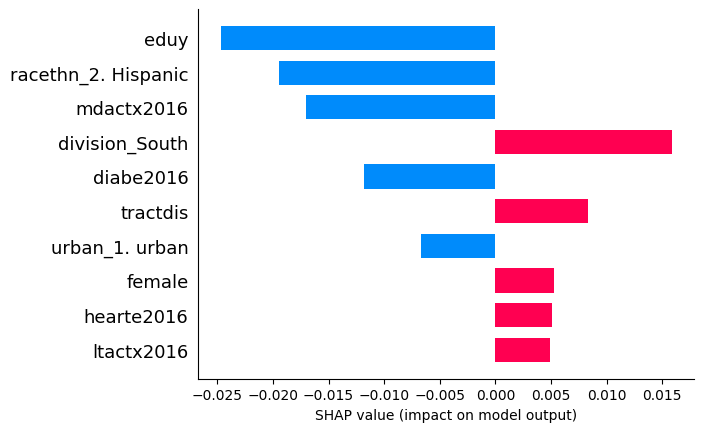

In [14]:
shap.bar_plot(shap_values[1], feature_names=interaction_predictors, max_display=10)

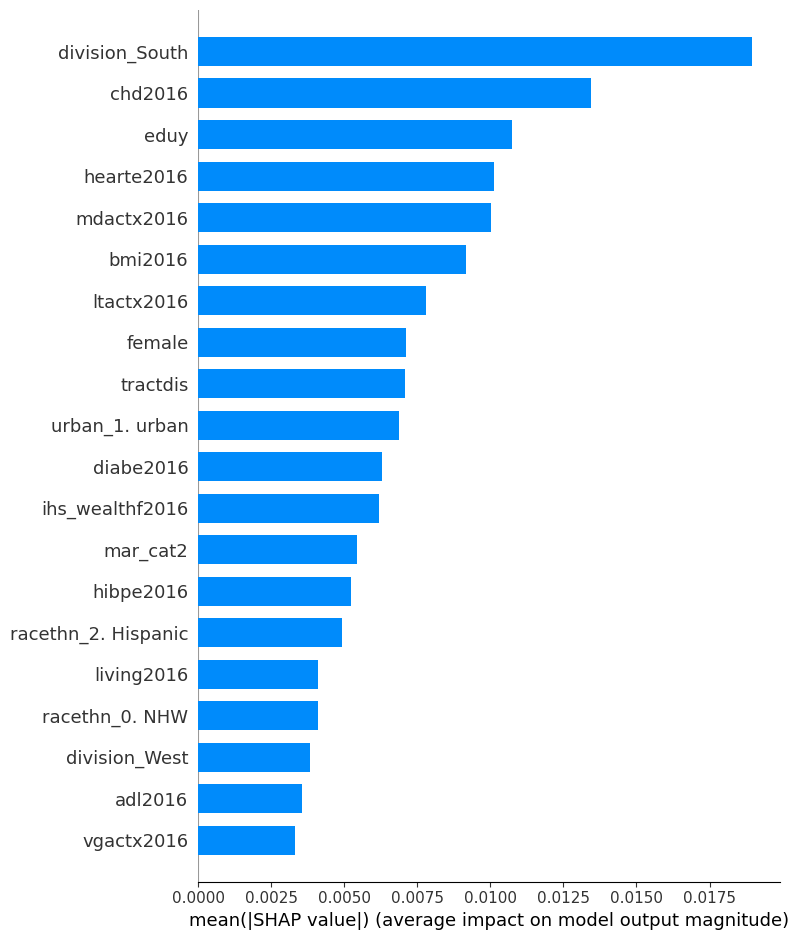

In [15]:
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:100, :].detach().cpu().numpy(), feature_names=interaction_predictors, plot_type='bar')